In [1]:
import os
import pandas as pd
import json
import folium
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO



# Question 1
## Part 1: A naive analysis

We load the data and compare the outcome for the two groups (participants and non-participants).

In [50]:
df_full = pd.read_csv('lalonde.csv')
df_full.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [40]:
df_treat_1 = df_full[df_full.treat == 1]['re78']
df_treat_0 = df_full[df_full.treat == 0]['re78']
df_treat_1.name = 'outcome_participants'
df_treat_0.name = 'outcome_nonparticipants'
print('Descriptive statistics for the participants:')
print(df_treat_1.describe())
print('\n\nDescriptive statistics for the non-participants:')
print(df_treat_0.describe())

Descriptive statistics for the participants:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: outcome_participants, dtype: float64


Descriptive statistics for the non-participants:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: outcome_nonparticipants, dtype: float64


Now we will plot the histograms of the outcome variable for the two groups (participants and non-participants) side by side (0 is untreated and 1 is treated):

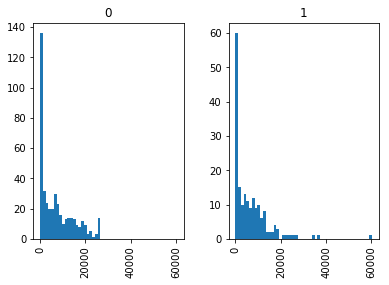

In [49]:
ax1, ax2 = df_full.hist(column='re78', by = 'treat', range=[0, df_full.re78.max()], bins = 50)
#ax1.set_yscale('log')
#ax2.set_yscale('log')